In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [ ]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

def draw_all_correspondences(all_points_1, all_points_2, query, prototypes) -> Tuple[plt.Figure, plt.Figure]:

    n_cols = len(prototypes)
    base_size = 5
    plot_ratio = n_cols / 2.0
    fig, ax = plt.subplots(2, n_cols, figsize=(plot_ratio*base_size, base_size))

    for counter, (prototype_img, points_1, points_2) in enumerate(zip(prototypes, all_points_1, all_points_2)):

      num_points = len(points_1)

      ax[0, counter].axis('off')
      ax[0, counter].imshow(imsc(query[0]))

      ax[1, counter].axis('off')
      ax[1, counter].imshow(imsc(prototype_img))

      if not points_1: continue

      if num_points > 15:
        cmap = plt.get_cmap('tab10')
      else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])

      colors = np.array([cmap(x) for x in range(num_points)])
      radius_1, radius_2 = 8, 1

      for point_1, point_2, color in zip(points_1, points_2, colors):

          y_1, x_1 = point_1
          circ_1_1 = plt.Circle((x_1, y_1), radius_1, facecolor=color, edgecolor='white', alpha=0.5)
          circ_1_2 = plt.Circle((x_1, y_1), radius_2, facecolor=color, edgecolor='white')
          ax[0, counter].add_patch(circ_1_1)
          ax[0, counter].add_patch(circ_1_2)

          y_2, x_2 = point_2
          circ_2_1 = plt.Circle((x_2, y_2), radius_1, facecolor=color, edgecolor='white', alpha=0.5)
          circ_2_2 = plt.Circle((x_2, y_2), radius_2, facecolor=color, edgecolor='white')
          ax[1, counter].add_patch(circ_2_1)
          ax[1, counter].add_patch(circ_2_2)

    plt.tight_layout()

    return fig

In [ ]:
#@title create dataset


from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y

[110, 120, 13, 74, 145, 138, 116, 87, 135, 102, 165, 63, 143, 41, 81, 41, 29, 175, 72, 151]


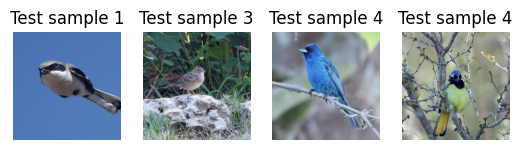

In [ ]:
#@title dataset and dataloader and load samples

import random

base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

random.seed(0)
inputs, labels = [], []
data_indices = random.sample(range(test_dataset.__len__()), 10)

for counter, data_idx in enumerate(data_indices):

  x, y = test_dataset.__getitem__(data_idx)

  inputs.append(x)
  labels.append(y)

print(labels)

plt.figure(1)
plt.subplot(141)
plt.imshow(imsc(inputs[0]))
plt.title('Test sample 1')
plt.axis('off')
plt.subplot(142)
plt.imshow(imsc(inputs[1]))
plt.title('Test sample 3')
plt.axis('off')
plt.subplot(143)
plt.imshow(imsc(inputs[2]))
plt.title('Test sample 4')
plt.axis('off')
plt.subplot(144)
plt.imshow(imsc(inputs[3]))
plt.title('Test sample 4')
plt.axis('off')
plt.show()


In [ ]:
#@title feature extractor

from PIL import Image
import requests
from transformers import CLIPVisionModel

model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16")


pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
#@title dataset for loading prototypes

class Prototype_Dataset(Dataset):
    def __init__(self, base_path, file_names, labels):

        self.base_path = base_path
        self.img_size = 224

        self.labels = labels
        self.file_names = file_names

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        y = self.labels[index]
        file_name = self.file_names[index]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y


In [ ]:
#@title keypoint counting classifier

from dataclasses import dataclass, field
from torch.nn.functional import cosine_similarity
from typing import List, Tuple
from sklearn.decomposition import PCA

@dataclass
class Keypoint_Counting_Classifier:
    encoder: nn.Module
    prototype_tokens: torch.Tensor
    prototype_file_names: List[str] = field(default_factory=list)
    prototype_labels: List[int] = field(default_factory=list)
    number_of_prototypes: int = 10
    number_of_pairs: int = 10
    number_of_classes = 200
    image_size: int = 224
    patch_size: int = 14
    stride: int = 14
    base_path: str = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'
    device: str = 'cuda'

    def __post_init__(self):

        self.encoder.eval()
        self.encoder = self.encoder.to(self.device)

        self.number_of_patches, self.token_dimensionality = self.get_number_of_patches_and_dim()

    def predict_and_plot(self, query) -> np.ndarray:

        query = query.to(self.device)
        top_k_similar_prototypes = self.get_k_closest_prototypes(query)

        query_patches = self.get_patches(query).reshape(-1, self.token_dimensionality)
        prototype_patches, prototype_images, prototype_labels = self.get_prototype_patches(top_k_similar_prototypes)
        prototype_patches = prototype_patches.reshape(-1, self.token_dimensionality)

        best_buddies, nn_query = self.get_best_buddies(query, query_patches, prototype_patches)
        cluster_labels, indices_to_show = self.cluster_best_buddies(best_buddies, query_patches, prototype_patches, nn_query)
        query_indices_to_show, prototype_indices_to_show = self.find_query_and_prototype_indices(best_buddies, indices_to_show, nn_query)
        paired_indices_to_show = self.find_pairs_of_query_and_prototype_indices(query_indices_to_show, prototype_indices_to_show)
        inidices_to_plot_1, inidices_to_plot_2 = self.convert_to_plot_indices(paired_indices_to_show)

        predictions = self.get_prediction(inidices_to_plot_1, inidices_to_plot_2, prototype_labels)

        fig = draw_all_correspondences(inidices_to_plot_1, inidices_to_plot_2, query, prototype_images)

        return predictions

    def get_k_closest_prototypes(self, query) -> torch.Tensor:

        query_token = self.encoder(query).pooler_output
        similarity = cosine_similarity(query_token, self.prototype_tokens)
        top_k_similar_prototypes_indices = torch.topk(similarity, self.number_of_prototypes)[1]

        return [i.item() for i in top_k_similar_prototypes_indices]

    def get_prototype_patches(self, top_k_indices) -> torch.Tensor:

        top_k_prototypes = [self.prototype_file_names[i] for i in top_k_indices]
        top_k_labels = [self.prototype_labels[i] for i in top_k_indices]

        prototype_dataset = Prototype_Dataset(self.base_path, top_k_prototypes, top_k_labels)
        prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_labels), shuffle=False, num_workers=0)
        prototypes, labels = next(iter(prototype_loader))

        patches = self.get_patches(prototypes.to(self.device))

        return patches, prototypes,labels

    def get_patches(self, query) -> torch.Tensor:
        return self.encoder(query).last_hidden_state[:, 1:, :].numpy(force=True)

    def get_best_buddies(self, query, query_patches, prototype_patches) -> Tuple[list, np.ndarray, list]:

        nn_query, _ = pairwise_distances_argmin_min(query_patches, prototype_patches, axis=1, metric='cosine')
        nn_prototypes, _ = pairwise_distances_argmin_min(query_patches, prototype_patches, axis=0, metric='cosine')

        best_buddies = nn_prototypes[nn_query] == np.arange(self.number_of_patches)

        foreground_masks = self.get_foreground_masks(np.concatenate((query_patches, prototype_patches)))
        #foreground_masks = self.update_foreground_masks(query, foreground_masks) # This is a prototype I am working on to fix the foreground masking. But still not working perfectly.

        n_cols = 10
        base_size = 5
        plot_ratio = n_cols / 2.0
        sqrt_of_patch = int(np.sqrt(self.number_of_patches))

        fig, ax = plt.subplots(2, n_cols, figsize=(plot_ratio*base_size, base_size))

        for counter, foreground_mask_i in enumerate(foreground_masks[1:]):

            ax[0, counter].axis('off')
            ax[0, counter].imshow(foreground_masks[0].reshape(sqrt_of_patch, sqrt_of_patch))

            ax[1, counter].axis('off')
            ax[1, counter].imshow(foreground_mask_i.reshape(sqrt_of_patch, sqrt_of_patch))

        plt.show()

        query_foreground_mask = foreground_masks[0]
        prototype_foreground_mask = foreground_masks[1:].flatten()

        prototypes_foreground_new_coordinates = nn_prototypes[prototype_foreground_mask]
        prototypes_foreground_mask_new_coordinates = np.zeros(self.number_of_patches, dtype=bool)
        prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True

        best_buddies = np.bitwise_and(best_buddies, query_foreground_mask)
        best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)

        if np.sum(best_buddies) < 15:
            best_buddies = nn_prototypes[nn_query] == np.arange(self.number_of_patches)

        return best_buddies, nn_query

    def get_foreground_masks(self, token_patches) -> np.ndarray:

        pca = PCA(n_components=10)
        pca_component_to_threshold = 1 # For CLIP, this seems to be quite stable for some reason.
        pca_features = pca.fit_transform(token_patches.reshape(-1, self.token_dimensionality))

        threshold_coefficient = 0.0
        threshold_base = np.mean(pca_features[:, pca_component_to_threshold])
        threshold_factor = threshold_coefficient * np.std(pca_features[:, pca_component_to_threshold])
        threshold = threshold_base + threshold_factor

        foreground_mask = pca_features[:, pca_component_to_threshold] > threshold

        plt.figure(1)
        plt.hist(pca_features[:, pca_component_to_threshold])
        plt.vlines(threshold, 0, 2000)
        plt.show()

        return np.array(foreground_mask).reshape(-1, self.number_of_patches)

    def update_foreground_masks(self, query, foreground_masks):

        query = query.to(self.device)
        top_k_similar_prototypes = self.get_k_closest_prototypes(query)
        prototype_patches, prototype_images, prototype_labels = self.get_prototype_patches(top_k_similar_prototypes)

        query_and_prototype_images = torch.cat((query, prototype_images.to(self.device)))

        foreground_masks_big = torch.tensor(foreground_masks.reshape(-1, 1, 14, 14), device=self.device)
        foreground_masks_big = torchvision.transforms.functional.resize(foreground_masks_big, size=224)

        query_and_prototype_images_0 = query_and_prototype_images * foreground_masks_big
        query_and_prototype_images_1 = query_and_prototype_images * ~foreground_masks_big

        unmasked_tokens = self.encoder(query_and_prototype_images).last_hidden_state[:, 1:, :]
        masked_tokens_0 = self.encoder(query_and_prototype_images_0).last_hidden_state[:, 1:, :]
        masked_tokens_1 = self.encoder(query_and_prototype_images_1).last_hidden_state[:, 1:, :]

        sim_0 = torch.mean(torch.nn.functional.cosine_similarity(unmasked_tokens, masked_tokens_0))
        sim_1 = torch.mean(torch.nn.functional.cosine_similarity(unmasked_tokens, masked_tokens_1))

        if sim_0 >= sim_1: return foreground_masks
        else: return ~foreground_masks

    def cluster_best_buddies(self, best_buddies, query_patches, prototype_patches, nn_query) -> Tuple[np.ndarray, np.ndarray]:

        bb_query = query_patches[best_buddies, :]
        bb_prototypes = prototype_patches[nn_query[best_buddies], :]

        bb_combined_patches = np.concatenate((bb_query, bb_prototypes), axis=1)
        bb_combined_patches = bb_combined_patches / np.linalg.norm(bb_combined_patches, axis=1, keepdims=True)

        kmeans = KMeans(n_clusters=self.number_of_pairs, random_state=0, n_init=10).fit(bb_combined_patches)
        indices_to_show = np.argmin(kmeans.transform(bb_combined_patches), axis=0)

        return kmeans.labels_, indices_to_show

    def find_query_and_prototype_indices(self, best_buddies, indices_to_show, nn_query) -> Tuple[np.ndarray, np.ndarray]:

        indices_to_show = np.nonzero(best_buddies)[0][indices_to_show]
        query_indices_to_show = np.arange(self.number_of_patches)[indices_to_show]
        prototype_indices_to_show = nn_query[indices_to_show]

        return query_indices_to_show, prototype_indices_to_show

    def find_pairs_of_query_and_prototype_indices(self, query_indices_to_show, prototype_indices_to_show):

        indices_query_prototype_pairs_to_show = []
        number_of_patches_prototypes = [np.prod(self.number_of_patches) for _ in range(self.number_of_prototypes)]

        for prototype_i in range(self.number_of_prototypes):

            indices_query_prototype_pairs_to_show_i = []

            for query_index, prototype_index in zip(query_indices_to_show, prototype_indices_to_show):
                if prototype_i*self.number_of_patches < prototype_index < (prototype_i+1)*self.number_of_patches:
                    new_prototype_index = prototype_index-prototype_i*self.number_of_patches
                    indices_query_prototype_pairs_to_show_i.append([query_index, new_prototype_index])
                else:
                    pass

            if not indices_query_prototype_pairs_to_show_i: indices_query_prototype_pairs_to_show_i.append([])
            indices_query_prototype_pairs_to_show.append(indices_query_prototype_pairs_to_show_i)

        return indices_query_prototype_pairs_to_show

    def convert_to_plot_indices(self, paired_indices_to_show):

        all_points_1 = []
        all_points_2 = []

        for pair_of_indices in paired_indices_to_show:

            points_1 = []
            points_2 = []

            if not any(pair_of_indices):
              all_points_1.append(points_1)
              all_points_2.append(points_2)
              continue

            query_y_to_show = (np.array(pair_of_indices)[:, 0] / np.sqrt(self.number_of_patches))
            query_x_to_show = (np.array(pair_of_indices)[:, 0] % np.sqrt(self.number_of_patches))
            prototype_y_to_show = (np.array(pair_of_indices)[:, 1] / np.sqrt(self.number_of_patches))
            prototype_x_to_show = (np.array(pair_of_indices)[:, 1] % np.sqrt(self.number_of_patches))

            for y1, x1, y2, x2 in zip(query_y_to_show, query_x_to_show, prototype_y_to_show, prototype_x_to_show):

                x1_show = (int(x1) - 1) * self.stride + self.stride + self.patch_size // 2
                y1_show = (int(y1) - 1) * self.stride + self.stride + self.patch_size // 2
                x2_show = (int(x2) - 1) * self.stride + self.stride + self.patch_size // 2
                y2_show = (int(y2) - 1) * self.stride + self.stride + self.patch_size // 2

                points_1.append((y1_show, x1_show))
                points_2.append((y2_show, x2_show))

            all_points_1.append(points_1)
            all_points_2.append(points_2)

        return all_points_1, all_points_2

    def get_number_of_patches_and_dim(self) -> Tuple[int, int]:

        dummy_input = torch.zeros(1, 3, self.image_size, self.image_size, device='cuda')
        _, number_of_patches, token_dimensionality = self.encoder(dummy_input).last_hidden_state.shape
        return number_of_patches-1, token_dimensionality

    def get_prediction(self, inidices_to_plot_1, inidices_to_plot_2, prototype_labels):

        labels_present = torch.unique(prototype_labels)

        class_predictions = np.zeros((self.number_of_classes,))

        for label_i in torch.unique(prototype_labels):

            label_indices = torch.where(label_i == prototype_labels)[0]

            for label_indices_i in label_indices:
                class_predictions[label_i] += len(inidices_to_plot_1[label_indices_i.item()])

        class_predictions /= self.number_of_pairs

        return class_predictions


prototype_file_names = pd.read_csv('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_file_names.csv')['0'].values
prototype_labels = pd.read_csv('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_labels.csv')['0'].values
prototype_representations = torch.load('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_representation.pth').to('cuda')

with torch.no_grad():
  kcc = Keypoint_Counting_Classifier(model, prototype_representations, prototype_file_names, prototype_labels)

<ipython-input-75-30f7d25a24f3>:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prototype_representations = torch.load('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_re

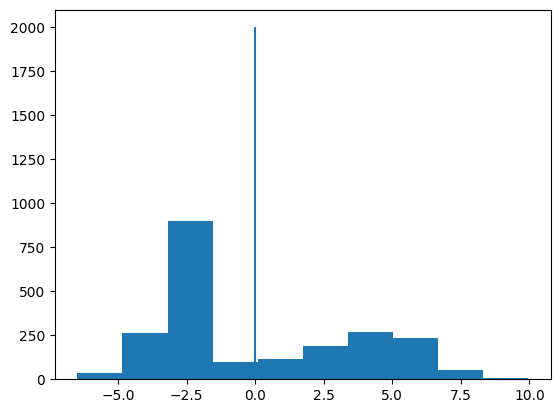

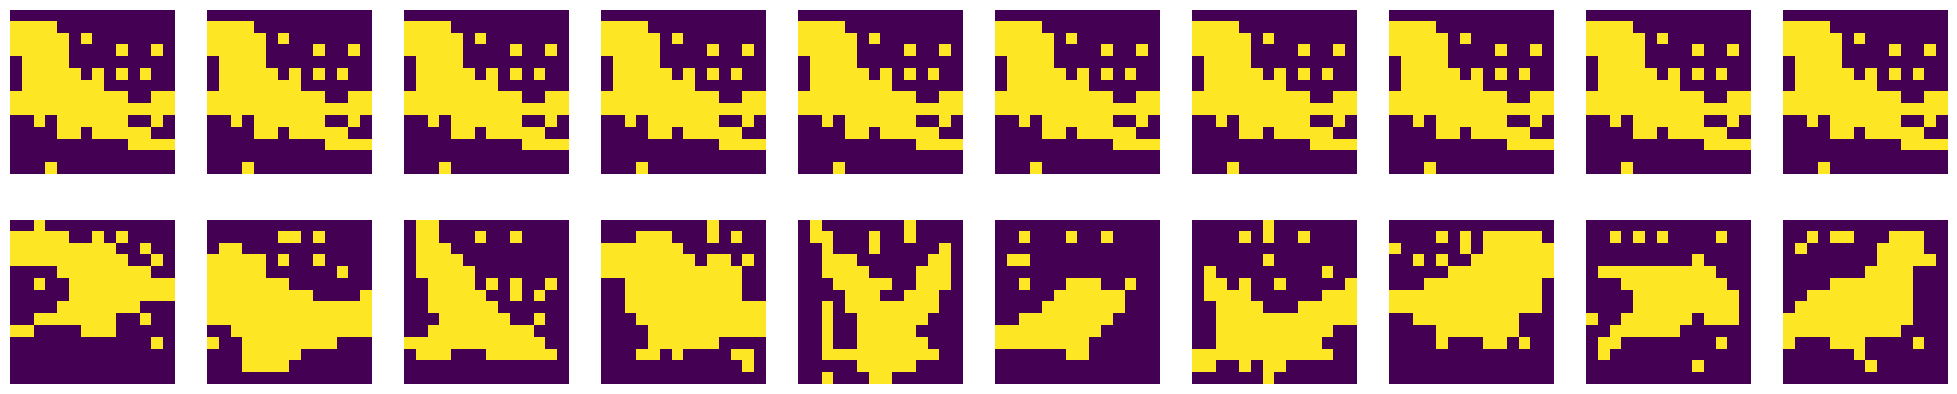

[ 72  73  60 145 140]
[0.  0.  0.1 0.3 0.6]
140
143


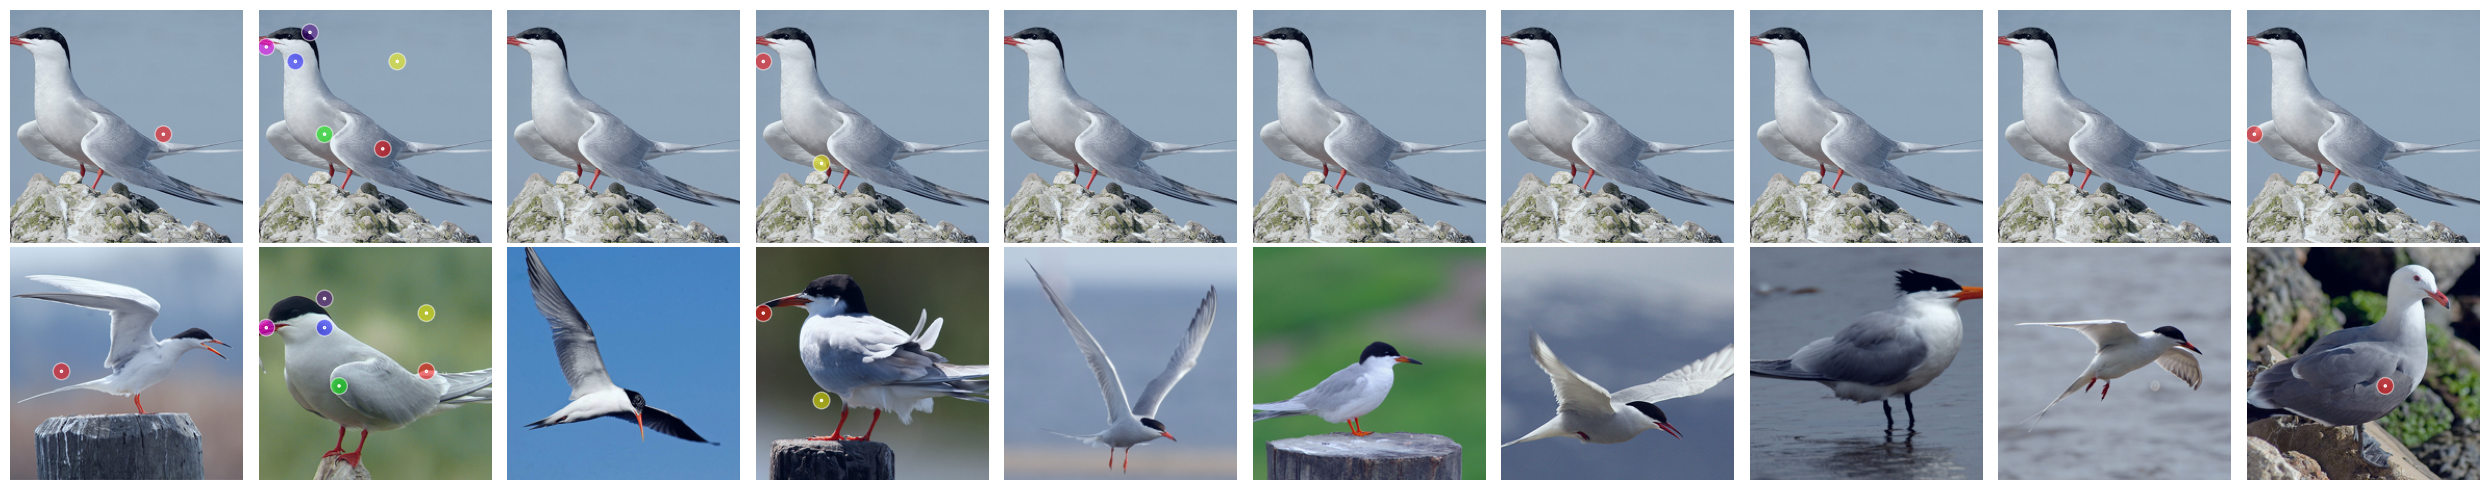

In [ ]:
#@title Testing block
# This block makes prediction for a query (defined by test_sample) and plots
# the forgeground / background thresholding along with the preidction
# and the explanation.

test_sample = 12
with torch.no_grad():
    predictions = kcc.predict_and_plot(inputs[test_sample].unsqueeze(0))

print(predictions.argsort()[-5:])
print(predictions[predictions.argsort()[-5:]])

print(predictions.argmax())
print(labels[test_sample])



Everything below here is not really relevant. This code is used to extract prototypes and do some other types of testing. I will leave it here so you can have a look if you are interested.

In [ ]:
#@title create classwise dataset for prototype extraction

from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

class Classwise_CUB(Dataset):
    def __init__(self, base_path, target_class, train=True):

        self.base_path = base_path
        self.target_class = target_class
        self.img_size = 224

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]
        self.classwise_filenames = []

        for label_value, file_name in zip(self.labels['label'].values, self.filenames[1].values):
            if (label_value-1) == target_class:
                self.classwise_filenames.append(file_name)
            else:
                pass

    def __len__(self):
        return len(self.classwise_filenames)

    def __getitem__(self, index):

        y = self.target_class
        file_name = self.classwise_filenames[index]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y, file_name

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
#@title embedding function

import random

@torch.no_grad()
def embed(encoder, dataloader):

    representations = None

    for batch_i, _, _ in dataloader:

          if representations is None:
              representations = encoder(batch_i.to('cuda')).pooler_output
          else:
              representations = torch.cat((representations, encoder(batch_i.to('cuda')).pooler_output))

    return representations

In [ ]:
!pip install scikit-learn-extra

In [ ]:
#@title create classwise datalaoder

from sklearn_extra.cluster import KMedoids

NUM_CLASSES = 200
NUM_PROTOTYPES_PER_CLASS = 5
REPRESENTATION_DIM = 768

prototype_file_names = []
prototype_labels = []
prototype_representations = []

base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/'

with torch.no_grad():
  for target_class in range(NUM_CLASSES):

      print(target_class)

      classwise_train_dataset = Classwise_CUB(base_path, target_class)
      classwise_train_loader = DataLoader(classwise_train_dataset, batch_size=15, shuffle=False, num_workers=0, drop_last=False)

      h = embed(model, classwise_train_loader)

      kmedoids = KMedoids(n_clusters=5).fit(h.numpy(force=True))

      for counter, idx in enumerate(kmedoids.medoid_indices_):
          x, y, file_name = classwise_train_dataset.__getitem__(idx)
          representations = model(x.unsqueeze(0).to('cuda'))

          prototype_file_names.append(file_name)
          prototype_labels.append(y)
          prototype_representations.append(representations.pooler_output.to('cpu'))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [ ]:
prototype_df.to_csv('drive/MyDrive/CoSegXAI/clip-vitp16_prototypes_5.csv', index=False)

In [ ]:
df = pd.read_csv('drive/MyDrive/CoSegXAI/clip-vitp16_prototypes_5.csv')

In [ ]:
import csv

with open('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_labels.csv', 'wb') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(prototype_labels)

TypeError: a bytes-like object is required, not 'str'

In [ ]:
pd.DataFrame(prototype_labels).to_csv('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_labels.csv')

In [ ]:
pd.DataFrame(prototype_file_names).to_csv('drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_file_names.csv')

In [ ]:
import csv

with open('drive/MyDrive/CoSegXAI/dinov2_vitb14_5_prototypes_file_names.csv', 'wb') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(prototype_file_names)

In [ ]:
a = torch.stack(prototype_representations).squeeze()
print(a.shape)

torch.Size([1000, 768])


In [ ]:
torch.save(torch.stack(prototype_representations).squeeze(), 'drive/MyDrive/CoSegXAI/clip-vitp16_5_prototypes_representation.pth')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

out = cosine_similarity(np.random.rand(1, 200), np.random.rand(150, 200))
ind = np.argpartition(out.flatten(), -4)[-4:]
print(ind)



[123 100  18 119]


In [ ]:
prototype_file_names = []
prototype_labels = []

for class_i, file_names in df.iterrows():
    for file_name in file_names.to_list():
        prototype_file_names.append(file_name)
        prototype_labels.append(class_i)



In [ ]:
top_k_indices = list(np.random.randint(0, len(prototype_file_names), 5).flatten())
top_k_prototypes = [prototype_file_names[i] for i in top_k_indices]
top_k_labels = [prototype_labels[i] for i in top_k_indices]


In [ ]:
#@title create classwise dataset for prototype extraction

class Prototype_Dataset(Dataset):
    def __init__(self, base_path, file_names, labels):

        self.base_path = base_path
        self.img_size = 392

        self.labels = labels
        self.file_names = file_names

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        y = self.labels[index]
        file_name = self.file_names[index]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).resize((self.img_size, self.img_size)).convert('RGB')
        x = self.transforms(x)

        return x, y

prototype_dataset = Prototype_Dataset(base_path, prototype_file_names, top_k_labels)
prototype_loader = DataLoader(prototype_dataset, batch_size=len(top_k_indices), shuffle=False, num_workers=0)

In [ ]:
train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

correct_labels = []
predicted_labels = []

for counter, (x, y) in enumerate(train_loader):

  print(counter)
  representations = model(x.to('cuda'))
  similarity = cosine_similarity(representations, prototype_representations)
  top_k_similar_prototypes_indices = torch.topk(similarity, 100)[1]
  correct_labels.append(y.item())
  predicted_labels.append([prototype_labels[i.item()] for i in top_k_similar_prototypes_indices])

  if counter == 499: break

In [ ]:
correct_label_among_top_k_nns = []
k = 10

for correct_labels_i, predicted_labels_i in zip(correct_labels, predicted_labels):

    correct_label_among_top_k_nns.append(correct_labels_i in predicted_labels_i[:k])

print(correct_label_among_top_k_nns)
print(sum(correct_label_among_top_k_nns) / 499)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [ ]:

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=0)

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(prototype_representations.numpy(force=True), prototype_labels)

with torch.no_grad():
  for counter, (x, y) in enumerate(test_loader):

      representations = model(x.to('cuda'))
      print(neigh.score(representations.numpy(force=True), y.numpy(force=True)))

      if counter == 10: break

0.9
1.0
0.98
0.76
0.88
0.88
0.92


KeyboardInterrupt: 

In [ ]:

test_dataset = CUB(base_path, train=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

acc_list = []

with torch.no_grad():
  for counter, (x, y) in enumerate(test_loader):
      predictions = kcc.get_prediction(x)

      acc_list.append(predictions.argmax() == y.item())



KeyboardInterrupt: 

In [ ]:
import torch
from torch.nn.functional import cosine_similarity

a = torch.zeros((5, 768))
b = torch.zeros((25, 768))

sims = cosine_similarity(a[None, :, :], b[:, None, :], dim=-1)
print(sims.shape)

for ai in a:
  print(cosine_similarity(ai, b, dim=-1))
  raise


torch.Size([25, 5])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


RuntimeError: No active exception to reraise